In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

excel_file = pd.ExcelFile('jobs.xlsx')
all = []

SITE_FIXES = {
        "The  Princess Royal Maternity Unit": "The Princess Royal Maternity Unit",
        "Gartnaval General Hospital": "Gartnavel General Hospital",
        "The Beatson West of Scotland Cancer Centre": "Beatson West of Scotland Cancer Centre",
        "Gilbert Road Medicine Group": "Gilbert Road Medical Group",
        "Drs Cheung, Al-Agilly and Morgan": "Drs Cheung, Al-Agilly & Morgan",
        "Kenmure Practice": "Kenmure Medical Practice",
        "Golden Jubilee University National  Hospital": "Golden Jubilee University National Hospital",
    }

    # Mapping of dirty values -> clean values for specialties
SPECIALTY_FIXES = {
        "Cardio-thoracic surgery": "Cardio-thoracic Surgery",
        "Palliative medicine": "Palliative Medicine",
    }

def get_jobs_dict():
    # read the excel file
    excel_file = pd.ExcelFile('jobs.xlsx')
    all = []
    # for each sheet in the workbook
    for sheet in excel_file.sheet_names:
        # read the sheet into a dataframe
        df = pd.read_excel(excel_file, sheet_name=sheet)
        # export the sheet to csv
        df.to_csv('jobs.csv', index=False)
        # convert the dataframe to a list of dictionaries
        json_list = df.to_dict(orient='records')
        
        def normalise(item):
            normalised_item = {}
            normalised_item['programmeTitle'] = item['Programme Title']
            normalised_item['deanery'] = item['Group Linked Sub-preference'].split()[:1][0]
            normalised_item['region'] = item['Group Linked Sub-preference'].split()[3]
            if normalised_item['region'] == "South":
                normalised_item['region'] = "South and SE"
            normalised_item['placements'] = []
            for i in range(6):
                placement = {
                    "site": item[f'Placement {i+1}: Site'],
                    "specialty": item[f'Placement {i+1}: Specialty']
                }
                description = item.get(f'Placement {i+1}: Description', None)
                if not pd.isna(description):
                    placement['description'] = description

                # Apply site and specialty fixes
                if placement['site'] in SITE_FIXES:
                    placement['site'] = SITE_FIXES[placement['site']]
                if placement['specialty'] in SPECIALTY_FIXES:
                    placement['specialty'] = SPECIALTY_FIXES[placement['specialty']]

                normalised_item['placements'].append(placement)

            return normalised_item

        for item in json_list:
            all.append(normalise(item))
    return all


jobs_dict = get_jobs_dict()


def remove_duplicates(jobs, verbose=True):
    """
    Remove exact duplicates and report near-duplicates.
    
    Returns:
        unique_jobs: list of jobs with exact duplicates removed
        duplicate_report: dict with detailed duplicate analysis
    """
    from collections import defaultdict

    def flatten_job(job):
        """Flatten a job dict into a comparable tuple of (field, value) pairs."""
        fields = {}
        for key, value in job.items():
            if key == "placements":
                for i, p in enumerate(value):
                    for pk, pv in p.items():
                        fields[f"placement_{i+1}_{pk}"] = str(pv)
            else:
                fields[key] = str(value)
        return fields

    def diff_fields(a, b):
        """Return list of (field, val_a, val_b) for fields that differ."""
        keys = set(a.keys()) | set(b.keys())
        diffs = []
        for k in sorted(keys):
            va, vb = a.get(k, "<missing>"), b.get(k, "<missing>")
            if va != vb:
                diffs.append((k, va, vb))
        return diffs

    # --- Pass 1: find exact duplicates ---
    seen = set()
    unique_jobs = []
    exact_dupes = []
    for job in jobs:
        identifier = "".join([str(v) for v in job.values()])
        if identifier not in seen:
            seen.add(identifier)
            unique_jobs.append(job)
        else:
            exact_dupes.append(job)

    # --- Pass 2: find near-duplicates (differ by N fields) ---
    flattened = [flatten_job(j) for j in unique_jobs]
    near_dupes = defaultdict(list)  # keyed by number of differing fields

    for i in range(len(flattened)):
        for j in range(i + 1, len(flattened)):
            diffs = diff_fields(flattened[i], flattened[j])
            n_diff = len(diffs)
            if 1 <= n_diff <= 3:  # flag pairs differing by 1–3 fields
                near_dupes[n_diff].append({
                    "job_a_index": i,
                    "job_b_index": j,
                    "job_a_title": unique_jobs[i].get("programmeTitle", "?"),
                    "job_b_title": unique_jobs[j].get("programmeTitle", "?"),
                    "differing_fields": diffs,
                })

    # --- Report ---
    report = {
        "total_input": len(jobs),
        "exact_duplicates": len(exact_dupes),
        "unique": len(unique_jobs),
        "near_duplicates": {k: v for k, v in sorted(near_dupes.items())},
    }

    if verbose:
        print("=" * 70)
        print("DUPLICATE ANALYSIS")
        print("=" * 70)
        print(f"  Total jobs in:       {report['total_input']}")
        print(f"  Exact duplicates:    {report['exact_duplicates']}")
        print(f"  Unique jobs out:     {report['unique']}")
        print()

        for n_diff in sorted(near_dupes.keys()):
            pairs = near_dupes[n_diff]
            print(f"  Near-duplicates differing by {n_diff} field{'s' if n_diff > 1 else ''}: {len(pairs)} pairs")
            for pair in pairs[:10]:  # show first 10 per category
                print(f"    [{pair['job_a_index']}] {pair['job_a_title']}")
                print(f"    [{pair['job_b_index']}] {pair['job_b_title']}")
                for field, va, vb in pair["differing_fields"]:
                    print(f"      ≠ {field}:")
                    print(f"          A: {va}")
                    print(f"          B: {vb}")
                print()
            if len(pairs) > 10:
                print(f"    ... and {len(pairs) - 10} more pairs")
                print()

    return unique_jobs, report


jobs_dict, dupe_report = remove_duplicates(jobs_dict)


# export the list of dictionaries to a json file
import json 
with open('jobs.json', 'w') as f:
    json.dump(jobs_dict, f, indent=4)

DUPLICATE ANALYSIS
  Total jobs in:       1536
  Exact duplicates:    363
  Unique jobs out:     1173

  Near-duplicates differing by 1 field: 26 pairs
    [120] ScotW01001
    [195] ScotW06001
      ≠ programmeTitle:
          A: ScotW01001
          B: ScotW06001

    [121] ScotW01002
    [196] ScotW06002
      ≠ programmeTitle:
          A: ScotW01002
          B: ScotW06002

    [122] ScotW01003
    [197] ScotW06003
      ≠ programmeTitle:
          A: ScotW01003
          B: ScotW06003

    [903] ScotS01007
    [1086] ScotS13013
      ≠ programmeTitle:
          A: ScotS01007
          B: ScotS13013

    [904] ScotS01008
    [1087] ScotS13014
      ≠ programmeTitle:
          A: ScotS01008
          B: ScotS13014

    [905] ScotS01009
    [1088] ScotS13015
      ≠ programmeTitle:
          A: ScotS01009
          B: ScotS13015

    [915] ScotS02004
    [1017] ScotS09004
      ≠ programmeTitle:
          A: ScotS02004
          B: ScotS09004

    [915] ScotS02004
    [1020] ScotS09

In [148]:

def get_sites(jobs):
    sites = set()
    for job in jobs:
        for i in range(6):
            sites.add(job["placements"][i]["site"])
    return sites
def get_specialties(jobs):
    specialties = set()
    for job in jobs:
        for i in range(6):
            specialties.add(job["placements"][i]["specialty"])
    return specialties

sites = get_sites(jobs_dict)
specialties = get_specialties(jobs_dict)

# Overview
Zoom out then zoom in

In [149]:
num_rotations = len(jobs_dict)
num_sites = len(sites)
num_specialties = len(specialties)


print(f"Ranking {num_rotations} rotations across {num_sites} sites and {num_specialties} specialties is no small feat.")
print(specialties)

Ranking 1173 rotations across 194 sites and 46 specialties is no small feat.
{'Plastic Surgery', 'Medical Oncology', 'Cardio-thoracic Surgery', 'Chemical Pathology', 'Ophthalmology', 'Renal Medicine', 'General (Internal) Medicine', 'Medical Microbiology', 'Respiratory Medicine', 'Vascular Surgery', 'Paediatric Intensive Care Medicine', 'Trauma and Orthopaedic Surgery', 'Intensive Care Medicine', 'Geriatric Medicine', nan, 'Paediatric Surgery', 'Clinical Oncology', 'Endocrinology and Diabetes Mellitus', 'General Psychiatry', 'Rehabilitation Medicine', 'Cardiology', 'Paediatrics', 'Psychiatry of Learning Disability', 'Anaesthetics', 'General Surgery', 'Old Age Psychiatry', 'Gastroenterology', 'Child and Adolescent Psychiatry', 'Emergency Medicine', 'Neurosurgery', 'Community Sexual and Reproductive Health', 'Histopathology', 'Obstetrics and Gynaecology', 'Haematology', 'Neurology', 'General Practice', 'Urology', 'Academic Foundation Programme', 'Acute Internal Medicine', 'Infectious Dise

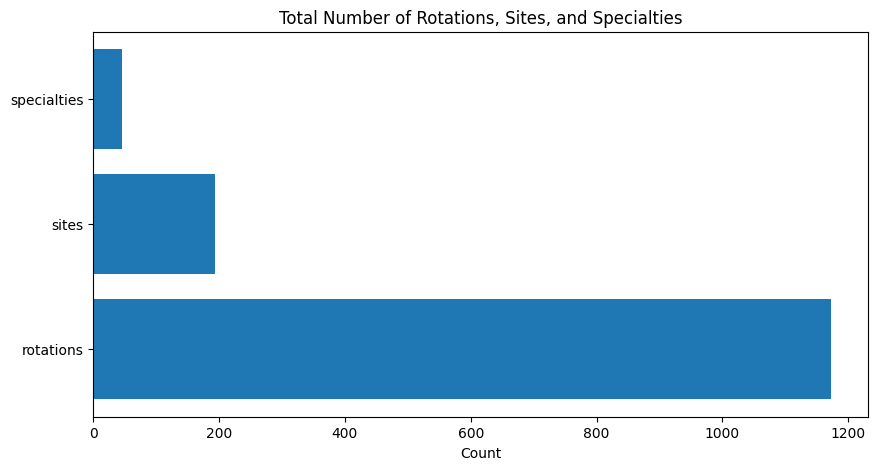

In [150]:
# bar chart of total number of each stat
import matplotlib.pyplot as plt
stats = {
    'rotations': num_rotations,
    'sites': num_sites,
    'specialties': num_specialties
}   
# horizontal bar chart of the stats, very wide, with the stat names on the y axis and the counts on the x axis
plt.figure(figsize=(10, 5))
plt.barh(list(stats.keys()), list(stats.values()))
plt.title('Total Number of Rotations, Sites, and Specialties')
plt.xlabel('Count')

plt.show()

# Regions
Of course, not all regions are built the same...

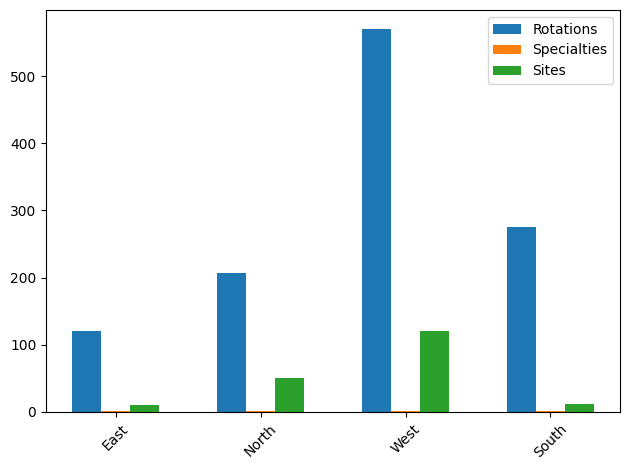

In [ ]:
# bar chart of job, specialty, and site counts per region
import matplotlib.pyplot as plt
regions = set(job['region'] for job in jobs_dict)
rotations_counts= {region: sum(1 for job in jobs_dict if job['region'] == region) for region in regions}
specialty_counts = {region: len(set(job["placements"][i]["specialty"] for job in jobs_dict if job['region'] == region for i in range(6))) for region in regions}
site_counts = {region: len(set(job["placements"][i]["site"] for job in jobs_dict if job['region'] == region for i in range(6))) for region in regions}  
x = range(len(regions))
plt.bar(x, rotations_counts.values(), width=0.2, label='Rotations', align='center')
plt.bar([i + 0.2 for i in x], specialty_counts.values(), width=0.2, label='Specialties', align='center')
plt.bar([i + 0.4 for i in x], site_counts.values(), width=0.2, label='Sites', align='center')
plt.xticks([i + 0.2 for i in x], regions, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
print(f"""
West and North have the most roations, with {rotations_counts['West']} each, this makes sense given 
they both have the most sites at {site_counts['West']} and {site_counts['North']} respectively. 

However variety in location does not mean variety in occupation with East having only {(specialty_counts['North'] - specialty_counts['East'])} less specialites
than North, but {site_counts['North'] - site_counts['East']} less sites.

      """)


West and North have the most roations, with 570 each, this makes sense given 
they both have the most sites at 121 and 50 respectively. 

However variety in location does not mean variety in occupation with East having only 0 less specialites
than North, but 39 less sites.

      


# Specialties
What will you actually spend 2 years doing? 

- What percentage of jobs have each specialty - general ideas of frequency over all placements is distinct from freqnecy at the job level i.e. gen med occurs in X percent of all palcements but if it in mre than placement per job it wil loccur in Y percent of all jobs. 
    - General Medicine appears in **84% of all jobs**. General Surgery in 80%. These two are near-unavoidable. 
    - this does mean that there are some big cohorts, particuarly at X hospiral an dY where Z of you start at thesame for tim epalcement a, b and c. 
    - The long tail is fascinating: **Dermatology exists in only 3 jobs**. Psychiatry of Learning Disability: 3. Cardiothoracic Surgery: 9.
    - 21 specialties are available in all 4 regions. But 4 are region-exclusive (Dermatology only in West, Cardiothoracic Surgery only in South & SE, etc.)

(big visualsation of specialty frequency)

- What percentage of jobs havea specialty in fy1 vs fy2.
    - F1 is dominated by Gen Med and Gen Surgery. F2 opens up dramatically: GP appears in 45% of jobs (but _only_ in F2), Emergency Medicine jumps from 54 F1 placements to 360 in F2, Psychiatry barely exists in F1 but is in 24% of F2 jobs.

(side by side viz of fy1 vs fy2 frequency)


### Rquired data
specialty_in_job_freq_per_region

placement_cohort_sizes_per_region

fy1_specialty_in_job_per_region

fy2_specialty_in_job_per_region


In [ ]:
def get_specialty_freq(jobs):
    specialty_freq = {}
    for job in jobs:
        specialties_seen_in_job = set()
        for i in range(6):
            specialty = job["placements"][i]["specialty"]
            if specialty in specialties_seen_in_job:
                continue
            specialties_seen_in_job.add(specialty)
            if specialty not in specialty_freq:
                specialty_freq[specialty] = 0
            specialty_freq[specialty] += 1
    return specialty_freq

def get_specialty_in_job_freq_per_region(jobs):
    specialty_freq_per_region = {}
    for job in jobs:
        specialties_seen_in_job = set()
        region = job['region']
        if region not in specialty_freq_per_region:
            specialty_freq_per_region[region] = {}
        for i in range(6):
            specialty = job["placements"][i]["specialty"]
            if specialty in specialties_seen_in_job:
                continue
            specialties_seen_in_job.add(specialty)
            if specialty not in specialty_freq_per_region[region]:
                specialty_freq_per_region[region][specialty] = 0
            specialty_freq_per_region[region][specialty] += 1
    return specialty_freq_per_region

def get_placement_cohort_size_per_region(jobs):
    cohort_size_per_region = {}
    for job in jobs:
        region = job['region']
        if region not in cohort_size_per_region:
            cohort_size_per_region[region] = {}
        for i in range(6):
            site = job["placements"][i]["site"]
            specialty = job["placements"][i]["specialty"]   
            if site and site != "None" and site.strip() != "" and specialty and specialty != "None" and specialty.strip() != "":
                if site not in cohort_size_per_region[region]:
                    cohort_size_per_region[region][site] = {}
                if specialty not in cohort_size_per_region[region][site]:
                    cohort_size_per_region[region][site][specialty] = {}
                if i not in cohort_size_per_region[region][site][specialty]:
                    cohort_size_per_region[region][site][specialty][i] = 0 
                cohort_size_per_region[region][site][specialty][i] += 1
    return cohort_size_per_region

def get_fyx_specialty_in_job_freq_per_region(jobs, x: 1 | 2):
    placement_indices = range(0, 3) if x == 1 else range(3, 6)
    specialty_freq_per_region = {}
    for job in jobs:
        specialties_seen_in_job = set()
        region = job['region']
        if region not in specialty_freq_per_region:
            specialty_freq_per_region[region] = {}
        for i in placement_indices:
            specialty = job["placements"][i]["specialty"]
            if specialty and specialty != "None" and specialty.strip() != "":
                if specialty in specialties_seen_in_job:
                    continue
                specialties_seen_in_job.add(specialty)
                if specialty not in specialty_freq_per_region[region]:
                    specialty_freq_per_region[region][specialty] = 0
                specialty_freq_per_region[region][specialty] += 1
    return specialty_freq_per_region

def _sorted_freq(freq_dict):
    """Sort a {name: count} dict descending by count."""
    return sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

def _print_top_bottom(sorted_items, n=3, total=None):
    """Print top and bottom n from a sorted list of (name, count) tuples."""
    fmt = lambda name, count: (
        f"      {name}: {count} ({(count/total)*100:.1f}%)" if total
        else f"      {name}: {count}"
    )
    print(f"    Top {n}:")
    for name, count in sorted_items[:n]:
        print(fmt(name, count))
    print(f"    Bottom {n}:")
    for name, count in sorted_items[-n:]:
        print(fmt(name, count))

def print_overall_freq(specialty_freq, num_jobs, top=5, bottom=3):
    """Print overall specialty frequency as % of jobs."""
    print("=" * 60)
    print("OVERALL SPECIALTY FREQUENCY (% of jobs)")
    print("=" * 60)
    sorted_specs = _sorted_freq(specialty_freq)
    print(f"  Top {top}:")
    for spec, freq in sorted_specs[:top]:
        print(f"    {spec}: {(freq/num_jobs)*100:.1f}%")
    print(f"  Bottom {bottom}:")
    for spec, freq in sorted_specs[-bottom:]:
        print(f"    {spec}: {(freq/num_jobs)*100:.1f}%")

def print_fy_freq_by_region(fy_freq, jobs, fy_label, regions, n=3):
    """Print top/bottom n specialties per region for FY1 or FY2."""
    print("\n" + "=" * 60)
    print(f"{fy_label} SPECIALTY FREQUENCY BY REGION")
    print("=" * 60)
    for region in regions:
        if region not in fy_freq:
            continue
        region_jobs = sum(1 for j in jobs if j['region'] == region)
        sorted_specs = _sorted_freq(fy_freq[region])
        print(f"\n  {region} ({region_jobs} jobs):")
        _print_top_bottom(sorted_specs, n=n, total=region_jobs)

def print_cohort_sizes_by_region(cohort_data, regions, n=3):
    """Print top/bottom n cohorts (site+specialty+placement) per region."""
    print("\n" + "=" * 60)
    print("LARGEST COHORTS BY REGION (site + specialty + placement #)")
    print("=" * 60)
    for region in regions:
        if region not in cohort_data:
            continue
        cohorts = []
        for site, specs in cohort_data[region].items():
            for spec, placements in specs.items():
                for p_num, count in placements.items():
                    cohorts.append((site, spec, p_num, count))
        cohorts.sort(key=lambda x: x[3], reverse=True)
        print(f"\n  {region}:")
        print(f"    Top {n} largest cohorts:")
        for site, spec, p_num, count in cohorts[:n]:
            print(f"      {site} — {spec} (P{p_num}): {count} people")
        print(f"    Smallest {n} cohorts:")
        for site, spec, p_num, count in cohorts[-n:]:
            print(f"      {site} — {spec} (P{p_num}): {count} people")

def print_all_summaries(jobs, regions=None, n=3):
    """Compute all data and print full summary."""
    if regions is None:
        regions = ["North", "East", "West", "South and SE"]

    specialty_freq = get_specialty_freq(jobs)
    cohort_data = get_placement_cohort_size_per_region(jobs)
    fy1_freq = get_fyx_specialty_in_job_freq_per_region(jobs, 1)
    fy2_freq = get_fyx_specialty_in_job_freq_per_region(jobs, 2)

    print_overall_freq(specialty_freq, len(jobs))
    print_fy_freq_by_region(fy1_freq, jobs, "FY1", regions, n=n)
    print_fy_freq_by_region(fy2_freq, jobs, "FY2", regions, n=n)
    print_cohort_sizes_by_region(cohort_data, regions, n=n)

    return specialty_freq, fy1_freq, fy2_freq, cohort_data

# --- Run ---
specialty_freq, fyx1_specialty_freq_per_region, fyx2_specialty_freq_per_region, cohort_size_per_region = print_all_summaries(jobs_dict)
specialty_freq_per_region = get_specialty_in_job_freq_per_region(jobs_dict)

KeyError: 'placements'

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter

TIERS = [
    (0.5, "Legendary", "#f59e0b"),
    (1.5, "Epic", "#a855f7"),
    (4.0, "Rare", "#3b82f6"),
    (10.0, "Uncommon", "#22c55e"),
    (float("inf"), "Common", "#64748b"),
]

def get_tier(pct):
    for threshold, name, color in TIERS:
        if pct < threshold:
            return name, color


def _tangent_positions(x1, y1, r1, x2, y2, r2, r):
    """Find positions for a circle of radius r tangent to two existing circles."""
    d = math.hypot(x2 - x1, y2 - y1)
    a, b = r1 + r, r2 + r
    if d < 1e-10 or d > a + b:
        return []
    cos_a = (a**2 + d**2 - b**2) / (2 * a * d)
    if abs(cos_a) > 1:
        return []
    angle = math.atan2(y2 - y1, x2 - x1)
    arc = math.acos(cos_a)
    return [
        (x1 + a * math.cos(angle + s * arc), y1 + a * math.sin(angle + s * arc))
        for s in (1, -1)
    ]


def pack_circles(radii):
    """Circle-pack by placing each new circle tangent to the closest pair."""
    if not radii:
        return []
    order = sorted(range(len(radii)), key=lambda i: -radii[i])
    positions = [None] * len(radii)
    placed = []

    for idx in order:
        r = radii[idx]
        if not placed:
            positions[idx] = (0.0, 0.0, r)
            placed.append((0.0, 0.0, r))
            continue
        if len(placed) == 1:
            px, py, pr = placed[0]
            pos = (px + pr + r, py, r)
            positions[idx] = pos
            placed.append(pos)
            continue

        best_pos, best_dist = None, float("inf")
        for i in range(len(placed)):
            for j in range(i + 1, len(placed)):
                x1, y1, r1 = placed[i]
                x2, y2, r2 = placed[j]
                for cx, cy in _tangent_positions(x1, y1, r1, x2, y2, r2, r):
                    dist = math.hypot(cx, cy)
                    if dist >= best_dist:
                        continue
                    has_overlap = False
                    for px, py, pr in placed:
                        if math.hypot(cx - px, cy - py) < pr + r - 0.5:
                            has_overlap = True
                            break
                    if not has_overlap:
                        best_pos, best_dist = (cx, cy), dist

        positions[idx] = (best_pos[0], best_pos[1], r)
        placed.append(positions[idx])

    return positions


def count_specialties(jobs, slots):
    """Count specialty occurrences across the given placement slots (0-indexed)."""
    counts = Counter()
    for job in jobs:
        for i in slots:
            spec = job["placements"][i]["specialty"]
            if spec and spec != "None" and spec.strip():
                counts[spec] += 1
    return counts


def plot_bubble_chart(region="All Regions", placement="All Placements"):
    """Draw a packed bubble chart of specialty frequency, coloured by rarity tier."""
    filtered = jobs_dict if region == "All Regions" else [j for j in jobs_dict if j["region"] == region]
    slots = range(6) if placement == "All Placements" else [int(placement.split()[-1]) - 1]
    counts = count_specialties(filtered, slots)

    if not counts:
        print("No data for this filter combination.")
        return

    total = sum(counts.values())
    items = sorted(counts.items(), key=lambda x: -x[1])
    max_count = items[0][1]
    MIN_R, MAX_R = 3, 45
    radii = [MIN_R + (MAX_R - MIN_R) * math.sqrt(c / max_count) for _, c in items]
    circles = pack_circles(radii)

    # --- Draw ---
    fig, ax = plt.subplots(figsize=(8, 14), facecolor="#0c0f14")
    ax.set_facecolor("#0c0f14")
    ax.set_aspect("equal")
    ax.axis("off")

    subtitle = " · ".join(
        p for p in [region if region != "All Regions" else None,
                    placement if placement != "All Placements" else None] if p
    ) or "All Regions · All Placements"
    ax.set_title(
        f"Specialty Rarity — {subtitle}\n{len(counts)} specialties across {total:,} placement slots",
        fontsize=16, color="#e8eaed", pad=20, fontweight=500, fontstyle="italic",
    )

    for i, (name, count) in enumerate(items):
        cx, cy, r = circles[i]
        pct = (count / total) * 100
        _, color = get_tier(pct)
        ax.add_patch(plt.Circle(
            (cx, cy), r,
            facecolor=to_rgba(color, 0.15),
            edgecolor=to_rgba(color, 0.6),
            linewidth=1.5,
        ))
        if r > 8:
            label = name if len(name) < 20 else name[:18] + "…"
            fs = max(5.5, min(10, r * 0.38))
            ax.text(cx, cy + 1, label, ha="center", va="center", fontsize=fs, color=color, fontweight=600)
            ax.text(cx, cy - r * 0.3, f"{count}  ({pct:.1f}%)", ha="center", va="center",
                    fontsize=max(5, fs - 1.5), color=to_rgba(color, 0.6))
        elif r > 5:
            ax.text(cx, cy, name[:12], ha="center", va="center",
                    fontsize=max(4.5, r * 0.4), color=color, fontweight=500)

    # Legend
    for idx, (threshold, tier_name, color) in enumerate(TIERS):
        lx, ly = -80, -70 - idx * 5
        labels = ["<0.5%", "0.5–1.5%", "1.5–4%", "4–10%", "≥10%"]
        ax.add_patch(plt.Circle((lx, ly), 1.5, facecolor=to_rgba(color, 0.3), edgecolor=to_rgba(color, 0.7), linewidth=1))
        ax.text(lx + 3.5, ly, f"{tier_name} ({labels[idx]})", fontsize=7, color=to_rgba(color, 0.9), va="center")

    ax.autoscale()
    ax.margins(0.05)
    plt.tight_layout()
    plt.show()


# --- Interactive widgets ---
region_options = ["All Regions"] + sorted(set(j["region"] for j in jobs_dict))
placement_options = ["All Placements"] + [f"Placement {i}" for i in range(1, 7)]

region_dd = widgets.Dropdown(options=region_options, value="All Regions", description="Region:", style={"description_width": "60px"})
placement_dd = widgets.Dropdown(options=placement_options, value="All Placements", description="Placement:", style={"description_width": "70px"})
output = widgets.Output()

def on_change(_):
    with output:
        clear_output(wait=True)
        plot_bubble_chart(region_dd.value, placement_dd.value)

region_dd.observe(on_change, names="value")
placement_dd.observe(on_change, names="value")

display(widgets.HBox([region_dd, placement_dd]))
display(output)
with output:
    plot_bubble_chart()

Output()

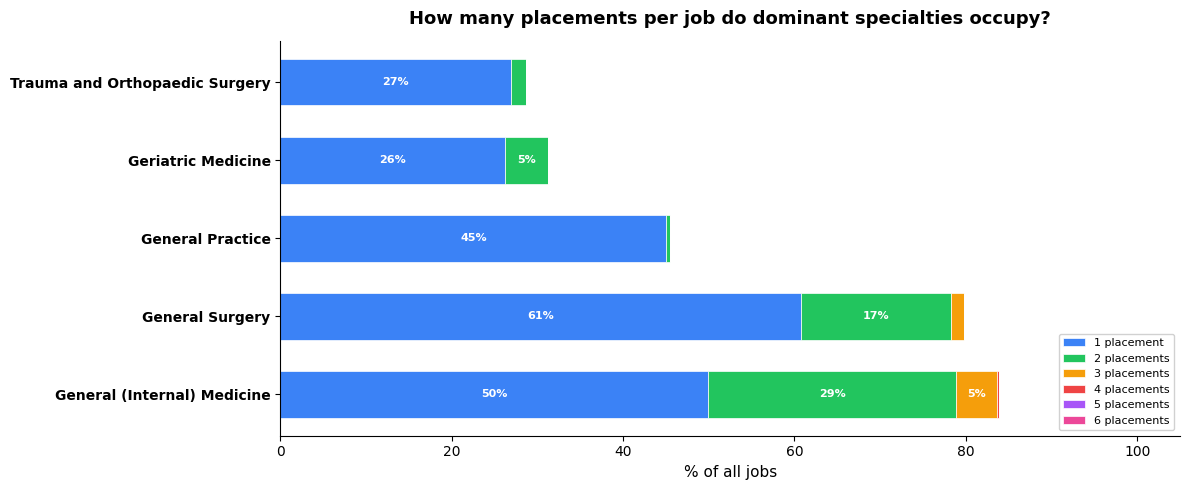


General (Internal) Medicine:
  Appears in 1288/1536 jobs (83.9%)
  Multiple placements in 521/1536 jobs (33.9%)
    1 placement: 767 jobs
    2 placements: 445 jobs
    3 placements: 72 jobs
    4 placements: 4 jobs

General Surgery:
  Appears in 1225/1536 jobs (79.8%)
  Multiple placements in 291/1536 jobs (18.9%)
    1 placement: 934 jobs
    2 placements: 268 jobs
    3 placements: 23 jobs


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def placement_count_distribution(jobs, specialty, max_placements=6):
    """Count how many jobs have exactly 0, 1, 2, ... N placements of a given specialty."""
    dist = Counter()
    for job in jobs:
        n = sum(
            1 for i in range(6)
            if job["placements"][i]["specialty"] == specialty
        )
        dist[n] += 1
    return {k: dist.get(k, 0) for k in range(max_placements + 1)}

# Top specialties by number of jobs they appear in
top_specialties = ["General (Internal) Medicine", "General Surgery", "General Practice",
                   "Geriatric Medicine", "Trauma and Orthopaedic Surgery"]

distributions = {spec: placement_count_distribution(jobs_dict, spec) for spec in top_specialties}

# --- Stacked horizontal bar chart (1–6 placements only) ---
fig, ax = plt.subplots(figsize=(12, 5))

max_n = max(max(d.keys()) for d in distributions.values())
colors = ["#3b82f6", "#22c55e", "#f59e0b", "#ef4444", "#a855f7", "#ec4899"]
labels = [f"{n} placement{'s' if n != 1 else ''}" for n in range(1, max_n + 1)]

y_pos = np.arange(len(top_specialties))
left = np.zeros(len(top_specialties))
total_jobs = len(jobs_dict)

for ni, n in enumerate(range(1, max_n + 1)):
    widths = [distributions[spec].get(n, 0) for spec in top_specialties]
    pcts = [w / total_jobs * 100 for w in widths]
    bars = ax.barh(y_pos, pcts, left=left, height=0.6,
                   color=colors[ni % len(colors)], label=labels[ni], edgecolor="white", linewidth=0.5)
    for bar, pct in zip(bars, pcts):
        if pct > 4:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                    f"{pct:.0f}%", ha="center", va="center", fontsize=8, fontweight=600, color="white")
    left += pcts

ax.set_yticks(y_pos)
ax.set_yticklabels(top_specialties, fontsize=10, fontweight=600)
ax.set_xlabel("% of all jobs", fontsize=11)
ax.set_title("How many placements per job do dominant specialties occupy?", fontsize=13, fontweight=600, pad=12)
ax.legend(loc="lower right", fontsize=8, framealpha=0.9)
ax.set_xlim(0, 105)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

# Print summary for the big two
for spec in top_specialties[:2]:
    dist = distributions[spec]
    multi = sum(v for k, v in dist.items() if k > 1)
    any_count = sum(v for k, v in dist.items() if k >= 1)
    print(f"\n{spec}:")
    print(f"  Appears in {any_count}/{total_jobs} jobs ({any_count/total_jobs*100:.1f}%)")
    print(f"  Multiple placements in {multi}/{total_jobs} jobs ({multi/total_jobs*100:.1f}%)")
    for n in sorted(dist.keys()):
        if dist[n] > 0 and n > 0:
            print(f"    {n} placement{'s' if n != 1 else ''}: {dist[n]} jobs")

# Blog Data Export
Export pre-computed JSON files for the interactive data blog on the landing page.
Each file is self-contained, well-named, and keyed by region for easy filtering.

In [ ]:
"""
=============================================================================
BLOG DATA EXPORT
=============================================================================
Exports pre-computed JSON files to web/public/data/ for the landing page
data blog. Each file is self-contained and keyed by region for easy filtering.

Run this cell after all analysis cells above have been executed.
=============================================================================
"""

import json
import os
from collections import Counter

OUTPUT_DIR = "../web/public/data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_json(filename, data):
    """Save data as JSON to the output directory."""
    path = os.path.join(OUTPUT_DIR, filename)
    with open(path, "w") as f:
        json.dump(data, f, indent=2)
    print(f"  Exported {filename}")

# ── 1. overview.json ──────────────────────────────────────────────────────────
# Hero section counters: total rotations, sites, specialties
overview = {
    "rotations": num_rotations,
    "sites": num_sites,
    "specialties": num_specialties,
}
save_json("overview.json", overview)

# ── 2. regions.json ───────────────────────────────────────────────────────────
# Region breakdown: rotations, sites, specialties per region
regions_data = {}
for region in ["North", "East", "West", "South and SE"]:
    region_jobs = [j for j in jobs_dict if j["region"] == region]
    region_sites = set()
    region_specialties = set()
    for job in region_jobs:
        for i in range(6):
            site = job["placements"][i]["site"]
            spec = job["placements"][i]["specialty"]
            if site and site != "None" and site.strip():
                region_sites.add(site)
            if spec and spec != "None" and spec.strip():
                region_specialties.add(spec)
    regions_data[region] = {
        "rotations": len(region_jobs),
        "sites": len(region_sites),
        "specialties": len(region_specialties),
    }
save_json("regions.json", regions_data)

# ── 3. specialty-tiers.json ───────────────────────────────────────────────────
# Bubble chart: specialty frequency with rarity tiers, overall + per region
TIERS_DEF = [
    (0.5, "Legendary", "#f59e0b"),
    (1.5, "Epic", "#a855f7"),
    (4.0, "Rare", "#3b82f6"),
    (10.0, "Uncommon", "#22c55e"),
    (float("inf"), "Common", "#64748b"),
]

def assign_tier(pct):
    for threshold, name, color in TIERS_DEF:
        if pct < threshold:
            return name, color
    return "Common", "#64748b"

def build_tier_list(freq_dict, total_jobs):
    """Convert a {specialty: count} dict into a sorted list with tier info."""
    items = []
    for name, count in sorted(freq_dict.items(), key=lambda x: -x[1]):
        pct = round((count / total_jobs) * 100, 2)
        tier, tier_color = assign_tier(pct)
        items.append({
            "name": name,
            "count": count,
            "pct": pct,
            "tier": tier,
            "tierColor": tier_color,
        })
    return items

# Overall specialty frequency (% of jobs containing the specialty)
specialty_tiers_data = {
    "all": build_tier_list(specialty_freq, num_rotations),
    "byRegion": {},
}
for region in ["North", "East", "West", "South and SE"]:
    region_total = sum(1 for j in jobs_dict if j["region"] == region)
    region_freq = specialty_freq_per_region.get(region, {})
    specialty_tiers_data["byRegion"][region] = build_tier_list(region_freq, region_total)

save_json("specialty-tiers.json", specialty_tiers_data)

# ── 4. fy-comparison.json ────────────────────────────────────────────────────
# FY1 vs FY2 specialty frequency, overall + per region
def build_fy_list(freq_per_region, total_jobs_per_region):
    """Build sorted specialty lists for FY data."""
    # Overall (sum across regions)
    overall = {}
    for region, specs in freq_per_region.items():
        for spec, count in specs.items():
            overall[spec] = overall.get(spec, 0) + count
    total = sum(total_jobs_per_region.values())
    all_list = [
        {"name": name, "count": count, "pct": round((count / total) * 100, 2)}
        for name, count in sorted(overall.items(), key=lambda x: -x[1])
    ]
    # Per region
    by_region = {}
    for region, specs in freq_per_region.items():
        region_total = total_jobs_per_region[region]
        by_region[region] = [
            {"name": name, "count": count, "pct": round((count / region_total) * 100, 2)}
            for name, count in sorted(specs.items(), key=lambda x: -x[1])
        ]
    return {"all": all_list, "byRegion": by_region}

total_jobs_per_region = {
    region: sum(1 for j in jobs_dict if j["region"] == region)
    for region in ["North", "East", "West", "South and SE"]
}

fy_comparison = {
    "fy1": build_fy_list(fyx1_specialty_freq_per_region, total_jobs_per_region),
    "fy2": build_fy_list(fyx2_specialty_freq_per_region, total_jobs_per_region),
}
save_json("fy-comparison.json", fy_comparison)

# ── 5. placement-distribution.json ───────────────────────────────────────────
# How many placements per job do dominant specialties occupy?
# Top 5 specialties + distribution of placement counts

top_specs = ["General (Internal) Medicine", "General Surgery", "General Practice",
             "Geriatric Medicine", "Trauma and Orthopaedic Surgery"]

def get_placement_dist(jobs, specialty):
    """Count how many jobs have exactly 0, 1, 2, ... N placements of a specialty."""
    dist = Counter()
    for job in jobs:
        n = sum(
            1 for i in range(6)
            if job["placements"][i]["specialty"] == specialty
        )
        if n > 0:
            dist[n] += 1
    return {str(k): v for k, v in sorted(dist.items())}

placement_dist = {
    "totalJobs": num_rotations,
    "specialties": [],
}
for spec in top_specs:
    # Overall
    overall_dist = get_placement_dist(jobs_dict, spec)
    # Per region
    by_region = {}
    for region in ["North", "East", "West", "South and SE"]:
        region_jobs = [j for j in jobs_dict if j["region"] == region]
        by_region[region] = {
            "totalJobs": len(region_jobs),
            "distribution": get_placement_dist(region_jobs, spec),
        }
    placement_dist["specialties"].append({
        "name": spec,
        "distribution": overall_dist,
        "byRegion": by_region,
    })

save_json("placement-distribution.json", placement_dist)

# ── 6. cohorts.json ──────────────────────────────────────────────────────────
# Largest and smallest cohorts per region
cohorts_data = {}
for region in ["North", "East", "West", "South and SE"]:
    if region not in cohort_size_per_region:
        continue
    cohorts = []
    for site, specs in cohort_size_per_region[region].items():
        for spec, placements in specs.items():
            for p_num, count in placements.items():
                cohorts.append({
                    "site": site,
                    "specialty": spec,
                    "placement": p_num,
                    "count": count,
                })
    cohorts.sort(key=lambda x: x["count"], reverse=True)
    cohorts_data[region] = {
        "largest": cohorts[:5],
        "smallest": cohorts[-5:],
    }

save_json("cohorts.json", cohorts_data)

print(f"\nDone! All blog data exported to {OUTPUT_DIR}/")